In [20]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
from math import cos, pi
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import levinson_durbin
from Levinson_Durbin.levinson import levinson_1d
from Piotrka.levinson_2 import levinson_2
import IPython
import bitarray

In [2]:
def error(coef, segment):
    e = np.zeros(256)
    n = 256
    
    for i in range(n):
        e[i] = segment[i]
        for j in range(0, 10):
            if i - j > 0:
                e[i] = e[i] + coef[j] * segment[i-j]
    
    return e

In [3]:
def quantize(signal, partitions, codebook):
    indices = []
    quanta = []
    len_part = len(partitions)
    for idx, datum in enumerate(signal):
        index = 0
        while index < len_part-1 and datum > partitions[index]:
            index += 1
        indices.append(index)
        quanta.append(codebook[index])
    return indices, quanta

In [4]:
def quantiz(quant_lvl, e, e_max):
    interval = (2 * e_max)/(quant_lvl-1)
    partition = [x for x in range(-e_max,e_max,int(interval))]
    codebook = [x for x in range(quant_lvl)]
    _, quant = quantize(e, partition, codebook)
    return quant

In [5]:
# Weight for flattening edges
def weight(k: int):
    return 0.5*(1-cos(((2*pi) / (257)) * k))

In [6]:
def play_sound(sound, rate=11025):
    return  IPython.display.display(IPython.display.Audio(sound, rate=rate))
# Read wave file
fs, track = scipy.io.wavfile.read("data/01.wav")

play_sound(track[:])


/tmp/ipykernel_5679/2738310824.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, track = scipy.io.wavfile.read("data/01.wav")


(array([[4.96128392e-07, 5.01224981e-06, 6.26064533e-06, ...,
         3.19867664e+01, 6.55746712e+00, 6.91023287e+00],
        [1.29493433e-05, 2.80464725e-06, 4.66615746e-06, ...,
         1.54162996e+02, 4.30277822e+01, 1.34611545e+01],
        [3.65047582e-06, 1.95997231e-06, 6.76570994e-07, ...,
         1.97599485e+01, 2.44014515e+01, 3.27786869e+01],
        ...,
        [8.35941253e-03, 1.16683392e-02, 4.68752049e-02, ...,
         1.60189169e+00, 3.00306337e+03, 1.70604202e+03],
        [5.83934149e-02, 3.25229402e-02, 4.71091687e-02, ...,
         1.64092844e+00, 1.82821063e+03, 1.13503753e+03],
        [6.70060991e-03, 2.18978789e-02, 4.50428232e-03, ...,
         6.31156679e-01, 1.25862046e+02, 2.07704850e+01]]),
 array([   0.        ,   10.76660156,   21.53320312,   32.29980469,
          43.06640625,   53.83300781,   64.59960938,   75.36621094,
          86.1328125 ,   96.89941406,  107.66601562,  118.43261719,
         129.19921875,  139.96582031,  150.73242188,  161.499

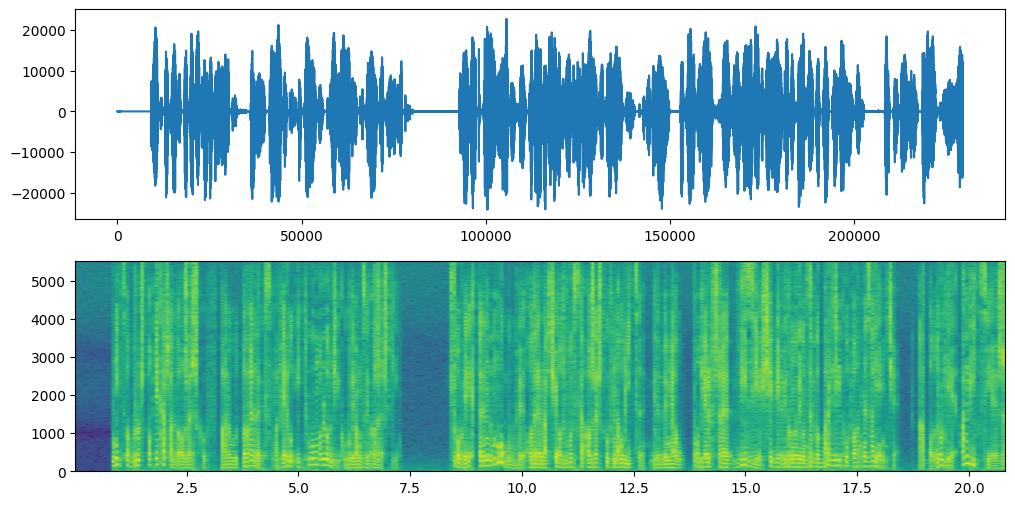

In [7]:
# Ploting track with specgram
plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
plt.plot(track)

plt.subplot(2, 1, 2)
plt.specgram(track, NFFT=1024, Fs=fs)

# plt.show()

In [8]:
# Creating segments with 256 samples 
segments = [track[:256]]
for i in range(256, len(track), 256):
    segments.append(track[i:i+256])

In [9]:
# Cell for printing purposes
segments[0]

array([  2,  -2,   3,  -3,   5,  -8,   8,  -7,   4,  -2,   5, -11,  11,
        -7,   4,  -2,  -1,   1,   2,  -2,   2,  -2,  -1,   4,  -4,   7,
        -7,   5,  -6,   6,  -6,   6,  -2,  -5,  11, -15,  13,  -7,   3,
        -1,   3,  -6,   5,  -5,   6,  -3,   0,  -1,  -2,   5,  -4,   3,
        -3,   0,   6,  -8,   6,  -5,   5,  -5,   8, -12,  12,  -8,   1,
         5,  -8,   7,  -3,   0,   0,   3,  -6,   9,  -9,   6,  -3,   3,
        -3,   0,   3,  -3,   2,  -2,   0,   3,  -4,   4,  -4,   4,  -6,
         5,   1,  -7,  10, -13,  13, -10,   7,  -4,   0,   4,  -7,  10,
       -11,   8,  -4,   4,  -4,   0,   4,  -4,   4,  -4,   1,   3,  -4,
         3,  -1,   0,   1,  -1,  -4,   9, -10,   8,  -2,  -5,   9, -10,
        11, -12,  13, -14,  11,  -4,   0,  -3,   3,   0,   1,  -2,  -2,
         1,   4,   0,  -4,   3,  -8,  14, -11,   8,  -6,   1,   1,   3,
        -6,   5,  -1,  -2,   5,  -9,  10,  -8,  10, -11,   7,  -3,   2,
        -1,   1,  -1,  -3,   6,  -6,   7,  -4,  -7,  14, -18,  2

In [10]:
# Filling last segments with zeros to make it 256 samples long
new_last_segment = np.append(segments[-1], np.zeros(13))
segments[-1] = new_last_segment

In [11]:
# Checking if all segments are 256 samples long
correct_len_segments = 0
for i in range(0, len(segments)):
    if len(segments[i]) == 256:
        correct_len_segments += 1
    else:
        print(f">>> Len for segment {i+1} is different and equals {len(segments[i])})")
if correct_len_segments == len(segments):
    print(f"All segments are length of 256 samples!")
else:
    print(f"Segments with length = {correct_len_segments}")

All segments are length of 256 samples!


In [12]:
# Prepare variable for storing flattened segments
flatten_segments = segments[:]
flatten_segments[0]

array([  2,  -2,   3,  -3,   5,  -8,   8,  -7,   4,  -2,   5, -11,  11,
        -7,   4,  -2,  -1,   1,   2,  -2,   2,  -2,  -1,   4,  -4,   7,
        -7,   5,  -6,   6,  -6,   6,  -2,  -5,  11, -15,  13,  -7,   3,
        -1,   3,  -6,   5,  -5,   6,  -3,   0,  -1,  -2,   5,  -4,   3,
        -3,   0,   6,  -8,   6,  -5,   5,  -5,   8, -12,  12,  -8,   1,
         5,  -8,   7,  -3,   0,   0,   3,  -6,   9,  -9,   6,  -3,   3,
        -3,   0,   3,  -3,   2,  -2,   0,   3,  -4,   4,  -4,   4,  -6,
         5,   1,  -7,  10, -13,  13, -10,   7,  -4,   0,   4,  -7,  10,
       -11,   8,  -4,   4,  -4,   0,   4,  -4,   4,  -4,   1,   3,  -4,
         3,  -1,   0,   1,  -1,  -4,   9, -10,   8,  -2,  -5,   9, -10,
        11, -12,  13, -14,  11,  -4,   0,  -3,   3,   0,   1,  -2,  -2,
         1,   4,   0,  -4,   3,  -8,  14, -11,   8,  -6,   1,   1,   3,
        -6,   5,  -1,  -2,   5,  -9,  10,  -8,  10, -11,   7,  -3,   2,
        -1,   1,  -1,  -3,   6,  -6,   7,  -4,  -7,  14, -18,  2

In [13]:
# Flattening samples in each segment
for i in range(0, len(flatten_segments)):
    for n in range(1, len(flatten_segments[i])):
        flatten_segments[i][n] *= weight(n)

In [14]:
# Ready flattened segments for Levinson-Durbin identification
flatten_segments[0]

array([  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,  -2,   2,  -1,   0,
         0,   0,  -1,   1,  -1,   1,   0,   0,   0,   0,   1,  -1,   1,
        -1,   0,   2,  -3,   2,  -2,   2,  -2,   3,  -5,   5,  -3,   0,
         2,  -4,   3,  -1,   0,   0,   1,  -3,   5,  -5,   3,  -1,   1,
        -1,   0,   2,  -2,   1,  -1,   0,   2,  -3,   3,  -3,   3,  -4,
         4,   0,  -5,   8, -10,  11,  -8,   6,  -3,   0,   3,  -6,   9,
       -10,   7,  -3,   3,  -3,   0,   3,  -3,   3,  -3,   0,   2,  -3,
         2,   0,   0,   0,   0,  -3,   8,  -9,   7,  -1,  -4,   8,  -9,
        10, -11,  12, -13,  10,  -3,   0,  -2,   2,   0,   0,  -1,  -1,
         0,   3,   0,  -3,   2,  -7,  13, -10,   7,  -5,   0,   0,   2,
        -5,   4,   0,  -1,   4,  -7,   8,  -6,   8,  -8,   5,  -2,   1,
         0,   0,   0,  -2,   4,  -4,   4,  -2,  -4,   9, -11,  1

In [15]:
# Prepare variable for storing AR coefficients assigned by LD algorithm
ld_arcoefs = []

In [22]:
# Imported from LD
# If True use levinson_dubrin
LD = False
for x in range(0, len(flatten_segments)):
    if LD:
        errors, arcoefs, reflection_coefs, sigmas, phi = levinson_durbin(flatten_segments[x],10)
    else:
        arcoefs = levinson_2(flatten_segments[x],256,10)
    ld_arcoefs.append(arcoefs)
len(ld_arcoefs)

/home/famousdeer/Desktop/Studia/Semestr3/Kaczmar/Projekt2/Kaczmar_Projekt2/Piotrka/levinson_2.py:7: RuntimeWarning: overflow encountered in short_scalars
  p[i] = p[i] + seg[t] * seg[t - i]


1794

In [23]:
segments[0]

array([  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,  -2,   2,  -1,   0,
         0,   0,  -1,   1,  -1,   1,   0,   0,   0,   0,   1,  -1,   1,
        -1,   0,   2,  -3,   2,  -2,   2,  -2,   3,  -5,   5,  -3,   0,
         2,  -4,   3,  -1,   0,   0,   1,  -3,   5,  -5,   3,  -1,   1,
        -1,   0,   2,  -2,   1,  -1,   0,   2,  -3,   3,  -3,   3,  -4,
         4,   0,  -5,   8, -10,  11,  -8,   6,  -3,   0,   3,  -6,   9,
       -10,   7,  -3,   3,  -3,   0,   3,  -3,   3,  -3,   0,   2,  -3,
         2,   0,   0,   0,   0,  -3,   8,  -9,   7,  -1,  -4,   8,  -9,
        10, -11,  12, -13,  10,  -3,   0,  -2,   2,   0,   0,  -1,  -1,
         0,   3,   0,  -3,   2,  -7,  13, -10,   7,  -5,   0,   0,   2,
        -5,   4,   0,  -1,   4,  -7,   8,  -6,   8,  -8,   5,  -2,   1,
         0,   0,   0,  -2,   4,  -4,   4,  -2,  -4,   9, -11,  1

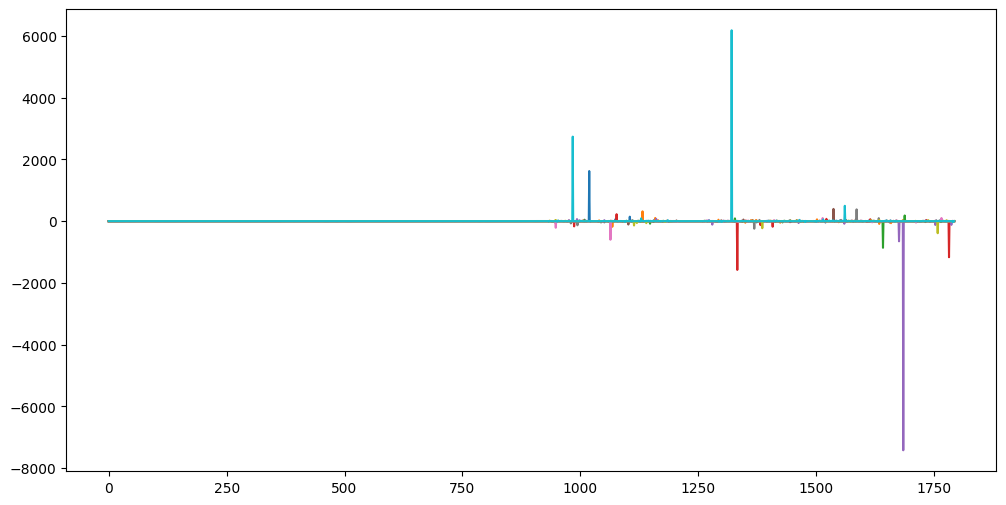

In [24]:
plt.figure(figsize=(12,6))

plt.plot(ld_arcoefs)

plt.show()

In [25]:
# Assigning error values
e = []
e_max = []
# quantz = []
for i in range(len(segments)):
    e.append(error(ld_arcoefs[i], segments[i]))
    e_max.append(max(abs(e[i])).astype(np.int16))
    # quantz.append(quantiz(4, e[i], e_max[i]))

In [26]:
len(e)

897

In [27]:
segments

[array([  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,  -2,   2,  -1,   0,
          0,   0,  -1,   1,  -1,   1,   0,   0,   0,   0,   1,  -1,   1,
         -1,   0,   2,  -3,   2,  -2,   2,  -2,   3,  -5,   5,  -3,   0,
          2,  -4,   3,  -1,   0,   0,   1,  -3,   5,  -5,   3,  -1,   1,
         -1,   0,   2,  -2,   1,  -1,   0,   2,  -3,   3,  -3,   3,  -4,
          4,   0,  -5,   8, -10,  11,  -8,   6,  -3,   0,   3,  -6,   9,
        -10,   7,  -3,   3,  -3,   0,   3,  -3,   3,  -3,   0,   2,  -3,
          2,   0,   0,   0,   0,  -3,   8,  -9,   7,  -1,  -4,   8,  -9,
         10, -11,  12, -13,  10,  -3,   0,  -2,   2,   0,   0,  -1,  -1,
          0,   3,   0,  -3,   2,  -7,  13, -10,   7,  -5,   0,   0,   2,
         -5,   4,   0,  -1,   4,  -7,   8,  -6,   8,  -8,   5,  -2,   1,
          0,   0,   0,  -2,   4,  -4,   4,  -2,  -4

In [55]:
# # Computing errors for each sample in each segment
# errors_og = []
# for segment, k in zip(segments, ld_arcoefs):
#     e = []
#     for i in range(0, len(segment)):
#         error = 0
#         for j in range(0, 10):
#             if i-j >= 0:
#                 error += k[j] * segment[i-j]
#         e.append(error)
#     errors_og.append(e)

In [56]:
# errors_og[0]

In [28]:
# plt.figure(figsize=(12,6))

# plt.plot(errors_og)

# plt.show()

In [58]:
# Computing max error absolute value for each segment
# e_max_list = []
# for segment in errors_og:
#     e_max = segment[0]
#     for i in range(0, len(segment)):
#         if abs(segment[i]) > e_max:
#             e_max = abs(segment[i])
#     e_max_list.append(e_max)
# len(e_max_list)

In [59]:
# plt.figure(figsize=(12,6))

# plt.plot(e_max_list)

# plt.show()

In [29]:
# Compute quantz
quantz = []
for i in range(len(segments)):
    quantz.append(quantiz(2, e[i], e_max[i]))
quantz

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [65]:
# quant_level = 4
# quants = []
# for idx, e in enumerate(e):
#     e_plus = [x + e_max[idx] for x in e]
#     step = (2 * e_max[idx]) / (quant_level - 1)
#     if step == 0:
#         quant = np.round(e_plus)
#     else:
#         quant = np.round(e_plus/step)
#     quants.append(quant.astype(np.int16))
# quants

In [30]:
len(quantz[0])

256

In [31]:
quantization_lvl = (np.max(quantz) + 1)
quantization_lvl

1

In [32]:
y2 = np.zeros(897*256)

In [33]:
for i in range(len(segments)):
    interval = (2 * int(e_max[i]))/(quantization_lvl-1)
    partition = [x for x in range(-int(e_max[i]),int(e_max[i]),int(interval))]
    for j in range(256):
        x = 0
        for k in range(10):
            if j - k > 0:
                x = x + ld_arcoefs[i][k] * y2[j-k]
        y2[i*256+j] = -x + partition[quantz[i][j]-1]

y2 = np.int16(y2)

sf.write("data/test.wav", y2, 11025)
play_sound(y2)

/tmp/ipykernel_5679/4110313493.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  interval = (2 * int(e_max[i]))/(quantization_lvl-1)


OverflowError: cannot convert float infinity to integer

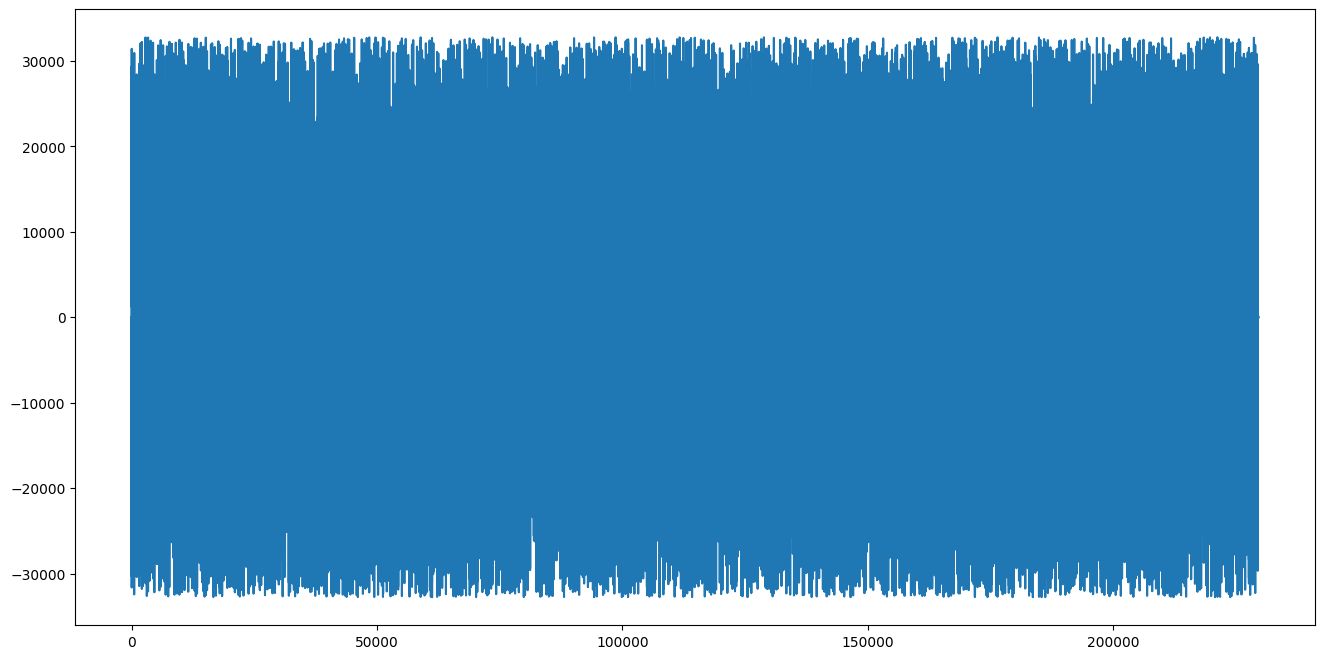

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y2)
plt.show()

In [9]:
letters = {'20': 'a',
           '21': 'ą',
           '22': 'b',
           '23': 'c',
           '24': 'd',
           '25': 'e',
           '26': 'ę',
           '27': 'f',
           '28': 'g',
           '29': 'h',
           '30': 'i',
           '31': 'j',
           '32': 'k',
           '33': 'l',
           '34': 'ł',
           '35': 'm',
           '36': 'n',
           '37': 'ń',
           '38': 'o',
           '39': 'ó',
           '40': 'p',
           '41': 'q',
           '42': 'r',
           '43': 's',
           '44': 'ś',
           '45': 't',
           '46': 'u',
           '47': 'v',
           '48': 'w',
           '49': 'x',
           '50': 'y',
           '51': 'z',
           '52': 'ź',
           '53': 'ż'}

In [4]:
numbers = "22 21 25 52 39 25 33 42 50 48 23 21 31 51 37 20 32 25 52 43 33 42 50 45 33 27 37 39 42 25 41 31 27 24 23 51 45 26 42 50 45 42 51 50 43 31 26 25 26 36 43 51 26 44 24 45 42 51 50 45 42 51 50 48 43 23 30 40 25 32 26 25 26 37 39 43 31 26 36 25 48 20 43 31 26 25 26 36 45 42 51 50 25 48 20 32 26 25 26 37"

In [7]:
clear_numbers = numbers.split()
clear_numbers

['22',
 '21',
 '25',
 '52',
 '39',
 '25',
 '33',
 '42',
 '50',
 '48',
 '23',
 '21',
 '31',
 '51',
 '37',
 '20',
 '32',
 '25',
 '52',
 '43',
 '33',
 '42',
 '50',
 '45',
 '33',
 '27',
 '37',
 '39',
 '42',
 '25',
 '41',
 '31',
 '27',
 '24',
 '23',
 '51',
 '45',
 '26',
 '42',
 '50',
 '45',
 '42',
 '51',
 '50',
 '43',
 '31',
 '26',
 '25',
 '26',
 '36',
 '43',
 '51',
 '26',
 '44',
 '24',
 '45',
 '42',
 '51',
 '50',
 '45',
 '42',
 '51',
 '50',
 '48',
 '43',
 '23',
 '30',
 '40',
 '25',
 '32',
 '26',
 '25',
 '26',
 '37',
 '39',
 '43',
 '31',
 '26',
 '36',
 '25',
 '48',
 '20',
 '43',
 '31',
 '26',
 '25',
 '26',
 '36',
 '45',
 '42',
 '51',
 '50',
 '25',
 '48',
 '20',
 '32',
 '26',
 '25',
 '26',
 '37']

In [11]:
word = []
for num in clear_numbers:
    word.append(letters[num])
word
final = ''
final.join(word)

'bąeźóelrywcąjzńakeźslrytlfńóreqjfdcztęrytrzysjęeęnszęśdtrzytrzywscipekęeęńósjęnewasjęeęntrzyewakęeęń'